# Infection Simulation


In [3]:
import datetime as dt
import random

import matplotlib.pyplot as plt
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker
import popy.utils as utils

In [4]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors(self):
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = self.model.p.infection_weight * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [5]:
class Home(popy.Location):
    def setup(self) -> None:
        self.weight_projection_denominator = 24

    def group(self, agent):
        return agent.hid

    def weight(self, agent):  # noqa: ARG002
        return 8


class Work(popy.Location):
    def setup(self):
        self.size = 10
        self.weight_projection_denominator = 24

    def join(self, agent):
        return agent.work_hours_day > 0

    def weight(self, agent):
        return agent.work_hours_day


class School(popy.Location):
    def setup(self):
        self.size = 25
        self.weight_projection_denominator = 24

    def join(self, agent) -> bool:
        return 6 <= agent.age <= 18

    def weight(self, agent):
        weight = 0

        # workday?
        if agent.model.date.weekday() < 5:
            # not ill?
            if (
                agent.infection_status != "symptomatic"
                or agent.infection_status == "symptomatic"
                and random.random() < 0.5
            ):
                # no holidays?
                if random.random() < self.model.get_timetable_entry()["school"]:
                    weight = 6

        return weight


class Friendship(popy.Location):
    def setup(self):
        self.size = 2
        self.weight_projection_denominator = 24

    def group(self, agent):
        return (abs(agent.age + random.randint(-5, 5)), agent.gender)

    def weight(self, agent):
        return 2 if agent.model.date.weekday() >= 5 else 0

In [6]:
class Model(popy.Model):
    def setup(self):
        self.date = dt.date(2022, 1, 1)
        df_soep = soep_faker.soep(size=self.p.n_agents)
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(
            agents=self.agents, location_classes=[Home, School, Work, Friendship],
        )

        self.infection_list = []

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"

        self.timetable = {
            dt.date(2020, 1, 1): {
                "school": 1,
            },
            dt.date(2020, 2, 1): {
                "school": 0,
            },
            dt.date(2020, 2, 15): {
                "school": 1,
            },
        }

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )
        self.date = self.date + dt.timedelta(days=1)

    def get_timetable_entry(self):
        for date_key in self.timetable:
            if date_key <= self.date:
                entry = self.timetable[date_key]
        return entry

Completed: 50 steps
Run time: 0:00:00.874757
Simulation finished


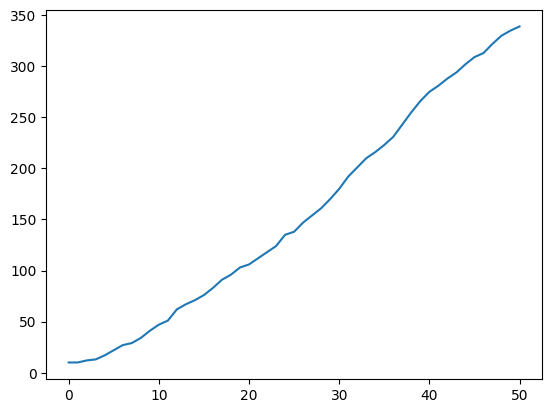

In [7]:
parameters = {
    "steps": 50,
    "n_agents": 1000,
    "infection_weight": 0.5,
}
model = Model(parameters=parameters)

results = model.run()

plt.plot(results.variables.Model.cumulative_infections)

In [8]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                   
                  count       mean       std   min   25%   50%   75%   max
location_class                                                            
Friendship        515.0   1.959223  0.479428   0.0   2.0   2.0   2.0   3.0
Home              329.0   3.039514  1.473843   1.0   2.0   3.0   4.0   9.0
School              3.0  28.666667  2.081666  27.0  27.5  28.0  29.5  31.0
Work               42.0   9.976190  0.154303   9.0  10.0  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    1000.00000
mean        2.51400
std         1.09316
min         1.00000
25%         2.00000
50%         2.00000
75%         3.00000
max         7.00000
Name: n_affiliated_locations, dtype: float64


,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
95,0.000,0.002,0.000,0.003,0.015,0.012,0.014,0.010,0.013,0.010,0.018,0.015,0.016,0.007,0.013,0.016,0.007,0.008,0.020,0.022
90,0.003,0.005,0.000,0.007,0.010,0.008,0.016,0.010,0.016,0.015,0.020,0.021,0.010,0.012,0.013,0.014,0.016,0.022,0.018,0.020
85,0.003,0.004,0.001,0.007,0.019,0.010,0.025,0.012,0.022,0.015,0.024,0.022,0.015,0.014,0.022,0.019,0.020,0.028,0.022,0.008
80,0.004,0.000,0.003,0.008,0.011,0.011,0.023,0.007,0.021,0.021,0.020,0.022,0.014,0.012,0.022,0.026,0.024,0.020,0.016,0.007
75,0.001,0.001,0.001,0.010,0.034,0.018,0.032,0.009,0.012,0.021,0.024,0.025,0.021,0.016,0.034,0.038,0.026,0.019,0.014,0.016
70,0.002,0.002,0.002,0.009,0.025,0.026,0.038,0.032,0.031,0.036,0.038,0.038,0.035,0.036,0.064,0.034,0.022,0.022,0.013,0.013
65,0.004,0.004,0.000,0.008,0.021,0.014,0.036,0.019,0.012,0.014,0.022,0.025,0.033,0.038,0.036,0.016,0.012,0.014,0.012,0.007
60,0.005,0.003,0.005,0.007,0.031,0.015,0.027,0.021,0.026,0.023,0.037,0.048,0.036,0.033,0.035,0.021,0.014,0.015,0.010,0.016
55,0.003,0.010,0.010,0.016,0.035,0.029,0.033,0.032,0.025,0.023,0.054,0.066,0.048,0.025,0.038,0.025,0.022,0.022,0.021,0.015
50,0.006,0.007,0.010,0.012,0.033,0.025,0.043,0.031,0.038,0.057,0.090,0.054,0.037,0.022,0.038,0.024,0.020,0.024,0.020,0.018


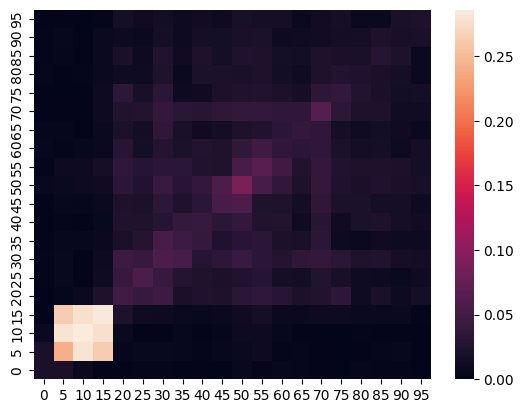

In [9]:
for agent in model.agents:
    agent.age_5 = utils.group_it(
        agent.age, start=0, step=5, n_steps=20, return_value="lower_bound",
    )

utils.create_contact_matrix(model.agents, attr="age_5", plot=True)
